# Mock for Song

## Notes

We work in distances of **Mpc/h** and masses of **Msun**.

We want to take an N-body simulation (currently MDPL but could be anything) and put galaxies in it in a way that creates a universe consistent with HSC observations. We are building an HSC mock catalog.

To do this we use the functional form which relates stellar mass to halo mass from [Behroozi2010](https://arxiv.org/pdf/1001.0015.pdf). As this is a mean relation we will also need a scatter term which we allow to vary linearly with log(halo mass). Finally, we get a good starting fit for the Behroozi functional form from [Leauthaud2012](https://arxiv.org/pdf/1104.0928.pdf) and for the scatter term from CB in prep.

As this functional form relates stellar mass - halo mass we initially generated stellar masses using various halo masses (Mvir, Mpeak). We were able to fit the SMF but clustering was low. After talking to Peter, this is apparently known and we should instead be populating stellar mass using Vmax@Mpeak. See [appendix A](./appendix.ipynb) for a description of how we get the initial coordinates.

With these initial fits we run an optimizer that takes into account both the SM and the clustering. We find that we can match the SMF well (all bins within the error bars) but have low clustering (HSC is 18.5 +/- 1.7, mock is 14 +/- 0.2). I don't really know how to evaluate whether this is good enough.

### How to run this

* If you want to re-run the opimizer, just run everything though  (takes O(hours)).
* If you just want to build the best fit model, run everything except the optimizer (takes O(1 minute)).

## Import etc...

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.interpolate, scipy.optimize

import data as d
import likelihood as l
import plots as p
import clustering as c

import emcee
from pyDOE import lhs

import smhm_fit
from get_sm_for_sim import get_sm_for_sim, get_smf

from Corrfunc.utils import convert_3d_counts_to_cf
import GPy
from sklearn.model_selection import train_test_split

%run ~/.jupyter/config.ipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data + initial config

In [2]:
# For the clustering, we look around objects with mass greater than this and
# count objects in the 0.1 dex smaller than it.
cen_sat_div = [11.65, 11.75, 11.85]

# [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]
# ^ Were the results from the very long run with ... some config (I don't really remember...)
# But I now needed to restart to get memory.

# See the appendix A for how we got these starting params
b_params = [2.4, 10.91, 0.6, 0.2, 0.2]
s_params = [-0.1, 0.5]
params = b_params + s_params
x_field = "Vmax@Mpeak"

# To speed things up we store a previous best_fit
best_fit = params = [ 2.37998488, 10.92042303,  0.35623719,  0.18581664,  0.27877097, -0.11090357,  0.51954824]

In [3]:
# The simulation data
sim_data, sim_size = d.load_mdpl()
print(np.log10(np.min(sim_data["halo_mvir"])))

# The observational data that we fit to
hsc_gals = d.load_hsc_gals()
obs_clust = np.array(
    [c.compute_hsc_clustering(hsc_gals, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
obs_smf = d.load_smf()

11.169422622696432
[Memory]5.2s, 0.1min    : Loading compute_hsc_clustering...
[Memory]5.2s, 0.1min    : Loading compute_hsc_clustering...
[Memory]5.2s, 0.1min    : Loading compute_hsc_clustering...


/home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/joblib/hashing.py:212: FutureWarning: Numpy has detected that you may be viewing or writing to an array returned by selecting multiple fields in a structured array. 

This code may break in numpy 1.16 because this will return a view instead of a copy -- see release notes for details.
  self._getbuffer(obj_c_contiguous.view(self.np.uint8)))


# Find bestfit to SMF with optimizer

In [ ]:
res = scipy.optimize.minimize(
    l.compute_chi2_n,
    x0 = params,
    args=(sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 3),
    method="Nelder-Mead",
)
assert res.success == True
best_fit = res.x

[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 2.047974372516754
[ 2.49898412 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 287.4558895771229
[ 2.37998488 11.46644418  0.35623719  0.18581664  0.27877097 -0.11090357  0.51954824] 932694.4411151003
[ 2.37998488 10.92042303  0.37404905  0.18581664  0.27877097 -0.11090357  0.51954824] 2.9115744045057492
[ 2.37998488 10.92042303  0.35623719  0.19510747  0.27877097 -0.11090357  0.51954824] 2.905680652491643
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.29270952 -0.11090357  0.51954824] 2.2966063655056312
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11644875  0.51954824] 22.936216957802213
[ 2.37998488 10.92042303  0.35623719  0.18581664  0.27877097 -0.11090357  0.54552565] 113.510966372972
[ 2.41398466 10.37440188  0.36132629  0.18847116  0.28275341 -0.11248791  0.52697036] 

# MCMC

## GP training

In [32]:
ranges = np.array([
    [2.3, 2.5],
    [10.7, 11.2],
    [0.3, 0.4],
    [0.1, 0.3],
    [0.2, 0.4],
    #[-0.15, -0.8],
    #[0.6, 0.4],
])

samples = ranges[:,0] + (ranges[:,1] - ranges[:,0]) * lhs(len(ranges), samples=1000)
samples = np.append(samples, np.ones((len(samples), 2)) * np.array([best_fit[-2], best_fit[-1]]), axis=1)

In [ ]:
chi2 = np.zeros(len(samples))
for i in range(len(samples)):
    chi2[i] = l.compute_chi2_n(samples[i], sim_data, obs_smf, obs_clust, sim_size, cen_sat_div, x_field, 3)

[ 2.30980896 11.15243061  0.30711285  0.1542654   0.2799815  -0.11090357  0.51954824] 

In [36]:
np.savez("intermediate_data/training", chi2=chi2, samples=samples)

## Build GP

In [154]:
inter = np.load("intermediate_data/training.npz")
chi2 = inter["chi2"]
samples = inter["samples"]

cut = np.isfinite(chi2) & (chi2 < 500)
samples = samples[cut][:,:5]
chi2 = chi2[cut].reshape((-1, 1))

train_chi2, test_chi2, train_samples, test_samples = train_test_split(chi2, samples, train_size=0.95)

 /home/christopher/.virtualenvs/greg/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning:From version 0.21, test_size will always complement train_size unless both are specified.


In [155]:
k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * train_chi2.flatten()))
#k_fixed = GPy.kern.Fixed(1, np.diag(0.1 * np.ones_like(train_chi2.flatten())))

k_rbf = GPy.kern.RBF(5, ARD=True)

In [156]:
m = GPy.models.GPRegression(train_samples, train_chi2, k_rbf + k_fixed)

# see http://www.nathan-rice.net/gp-python/
# https://github.com/SheffieldML/GPy/issues/196

m.Gaussian_noise.constrain_fixed(0)
m.kern.fixed.variance.constrain_fixed(1)

array([0])

In [157]:
m.optimize(messages=True)

[(0, 50.0), (0, 50.0)]

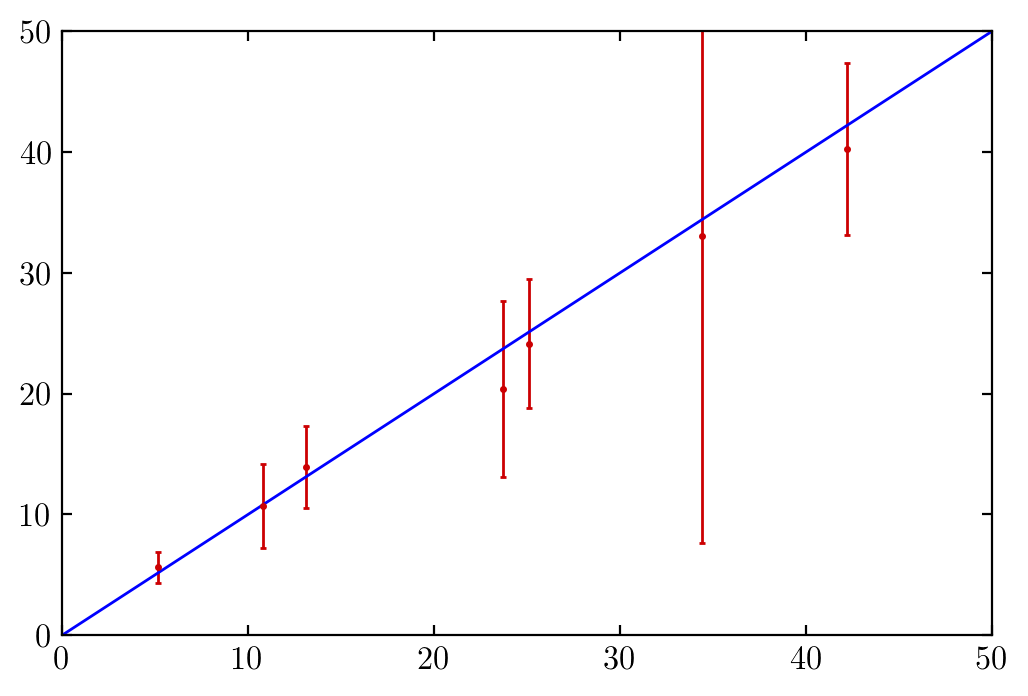

In [158]:
true = test_chi2.flatten()
pred = m.predict(test_samples, kern=m.kern.rbf)
gp = pred[0].flatten()
gp_err = pred[1].flatten()


lim = 5e1
_, ax = plt.subplots()
ax.errorbar(true, gp, yerr=gp_err, ls="", marker=".")
ax.plot([0, lim], [0, lim])
ax.set(xlim=(0, lim), ylim=(0, lim))

# Build bestfit model and compare to observations

In [11]:
log_stellar_masses = get_sm_for_sim(sim_data, best_fit[:5], best_fit[5:], x_field)

This is not good [274] [298]


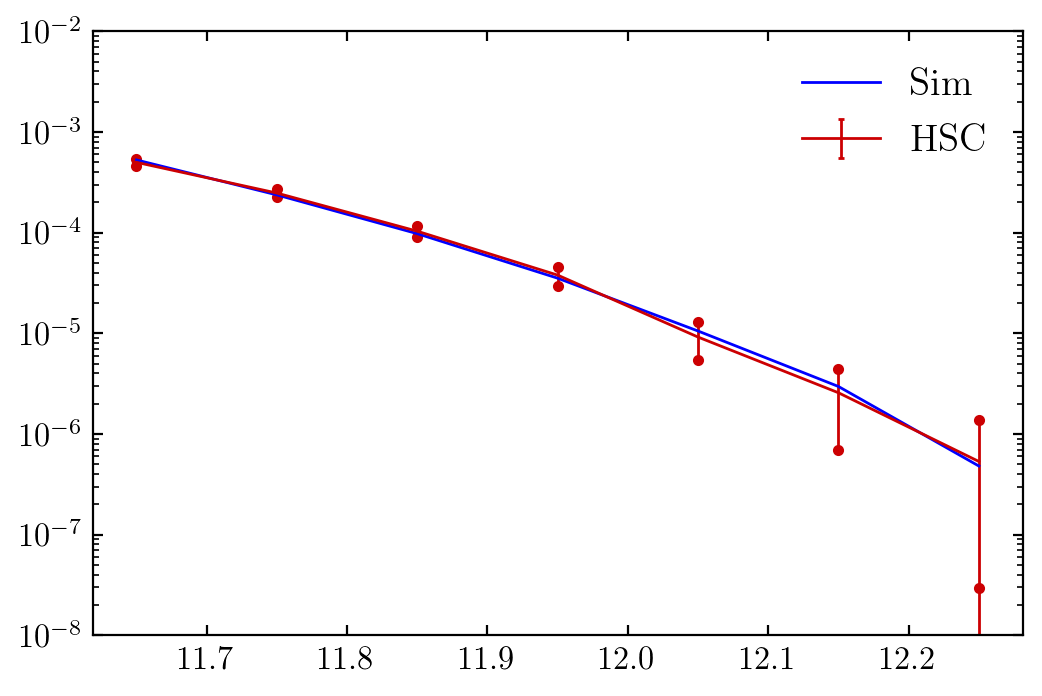

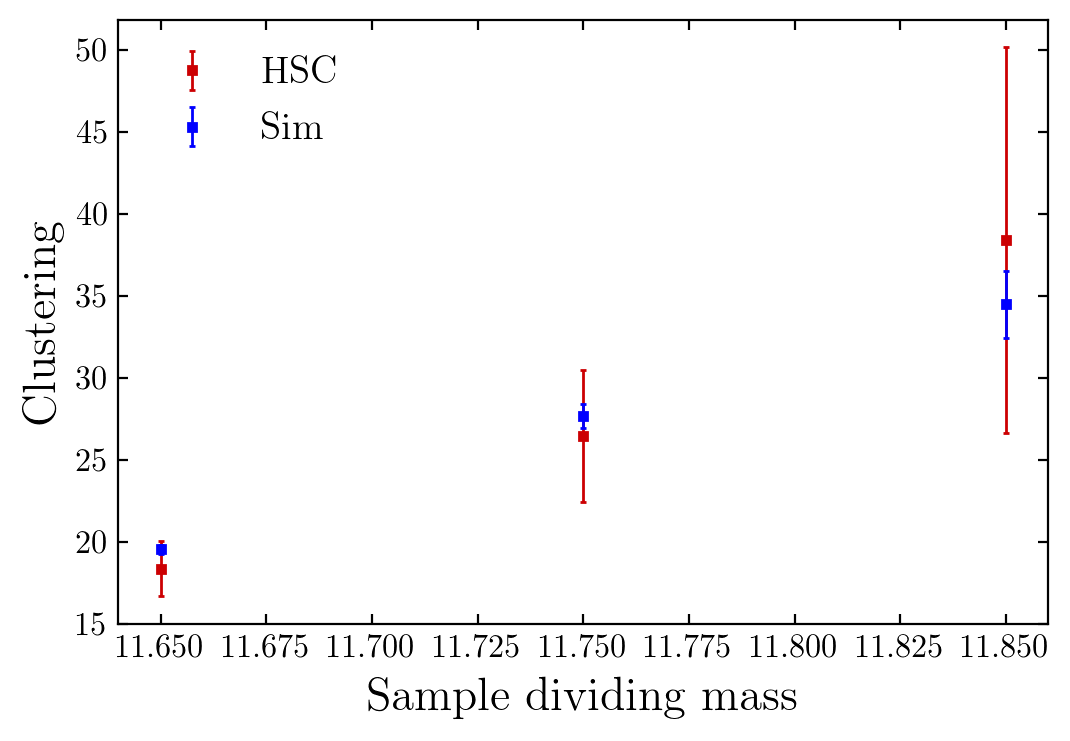

In [12]:
fig, ax = p.plot_smfs(obs_smf, log_stellar_masses, sim_size)
ax.set(ylim=(1e-8, 1e-2));

sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_smf.png", dpi=300)

fig, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")
fig.savefig("/home/christopher/research/satellite_fraction/cb/writeup/images/fit_clust.png", dpi=300)

# Save out mock

In [9]:
sim_data_out = np.lib.recfunctions.append_fields(sim_data, names="stellar_mass", dtypes=np.float64, data=np.power(10, log_stellar_masses))
sim_data_out = np.lib.recfunctions.rename_fields(sim_data_out, {"halo_mvir": "Mpeak"})
np.save("mocks/new", np.ma.getdata(sim_data_out))

# From meeting

In [1]:
sim_clust = np.array(
    [c.compute_sim_clustering(sim_data, sim_size, log_stellar_masses, div) for div in cen_sat_div],
    dtype=[("clustering", np.float64), ("err", np.float64)])

_, ax = plt.subplots()
ax.errorbar(cen_sat_div, obs_clust["clustering"], yerr=obs_clust["err"], ls="None", marker="s", label="HSC")
ax.errorbar(cen_sat_div, sim_clust["clustering"], yerr=sim_clust["err"], ls="None", marker="s", label="Sim")
ax.legend()

ax.set(ylabel="Clustering", xlabel="Sample dividing mass")

NameError: name 'np' is not defined